# Predictive Maintenance Model

## Customize Enviornment

In [2]:
# load packages
packages <- c("purrr", "doMC", "RMySQL", "lubridate", "ggplot2", "caret", "DMwR", "pROC")
purrr::walk(packages, library, character.only = TRUE, warn.conflicts = FALSE)

# set default plot size
options(repr.plot.width=10, repr.plot.height=6)

# configure multicore processing
registerDoMC(cores=8)

## Load Data

In [3]:
# create an open connection to the database
cn <- dbConnect(drv = RMySQL::MySQL(),
                host = "host",
                port = 3306,
                user = "user",
                password = "password",
                dbname = "db")

# query the database and store the results into a DataFrame
df_all <- dbGetQuery(cn, "SELECT * FROM machine3_1_hour_before_down")
dbDisconnect(cn)

[1] TRUE

In [4]:
# remove rows without complete data
df <- df_all[complete.cases(df_all),]
nrow(df)

[1] 10281

In [5]:
# show a sample of the data
head(df)

Datetime_hour,DOWN,CircFan1_max,CircFan1_mean,CircFan1_min,CircFan1_std,CircFan2_max,CircFan2_mean,CircFan2_min,CircFan2_std,⋯,Valve4_min,Valve4_std,Valve5_max,Valve5_mean,Valve5_min,Valve5_std,Valve6_max,Valve6_mean,Valve6_min,Valve6_std
2015-01-01 00:00:00,0,100,100,100,0,100,100,100,0,⋯,100,0.000000,100,100.0,100,0.000000,100,100,100,0
2015-01-01 01:00:00,0,100,100,100,0,100,100,100,0,⋯,98,0.461133,100,100.0,100,0.000000,100,100,100,0
2015-01-01 02:00:00,0,100,100,100,0,100,100,100,0,⋯,81,4.944404,100,99.5,91,1.943158,100,100,100,0
2015-01-01 03:00:00,0,100,100,100,0,100,100,100,0,⋯,94,1.381736,100,100.0,100,0.000000,100,100,100,0
2015-01-01 04:00:00,0,100,100,100,0,100,100,100,0,⋯,92,1.695498,100,100.0,100,0.000000,100,100,100,0
2015-01-01 05:00:00,0,100,100,100,0,100,100,100,0,⋯,100,0.000000,100,100.0,100,0.000000,100,100,100,0


## Inspect Data

In [6]:
# rename variable, convert to factor, and set names
names(df)[names(df)=="DOWN"] <- "Class"
df$Class  <- as.factor(df$Class)
levels(df$Class) <- make.names(c("notDown", "down"))

In [7]:
# convert data type for datetime
df$Datetime_hour <- ymd_hms(df$Datetime)

In [8]:
# look at the number of variables in the dataframe
cat("Number of variables before:")
ncol(df)

# drop variables are are constant
df <- df[sapply(df, function(x) length(unique(na.omit(x)))) > 1]
    
# look at the number of variables again after dropping constant variables
cat("\nNumber of variables after:")
ncol(df)

Number of variables before:

[1] 211


Number of variables after:

[1] 196

## Partition Data
Randomly split data into 60% training, 20% test, 20% validation

In [9]:
# randomly split dataframe into 60% for training
set.seed(1234)
trainIndex <- createDataPartition(df$Class, 
                                  p = .6, 
                                  list = FALSE, 
                                  times = 1)

imbal_train <- df[ trainIndex,]
non_train   <- df[-trainIndex,]

# split the remaining 40% into test and validation
set.seed(1234)
trainIndex <- createDataPartition(non_train$Class, 
                                  p = .5, 
                                  list = FALSE, 
                                  times = 1)

imbal_test  <- non_train[ trainIndex,]
imbal_valid <- non_train[-trainIndex,]

In [10]:
# seperate datetime_hour from each dataset so that I can join it up late
train_dt <- imbal_train$Datetime_hour
imbal_train$Datetime_hour <- NULL

test_dt <- imbal_test$Datetime_hour
imbal_test$Datetime_hour <- NULL

valid_dt <- imbal_valid$Datetime_hour
imbal_valid$Datetime_hour <- NULL

In [11]:
# compare downtime ratio in training and test
cat("Downtime ratio in training data:")
prop.table(table(imbal_train$Class))

cat("\nDowntime ratio in test data:")
prop.table(table(imbal_test$Class))

cat("\nDowntime ratio in validation data:")
prop.table(table(imbal_valid$Class))

Downtime ratio in training data:


  notDown      down 
0.9615821 0.0384179 


Downtime ratio in test data:


   notDown       down 
0.96157588 0.03842412 


Downtime ratio in validation data:


   notDown       down 
0.96157588 0.03842412 

## Balance Data
SMOTE (Synthetic Minority Over-sampling Technique) works by creating synthetic samples from the under-represented class instead of creating copies

In [12]:
set.seed(1234)
smote_train <- SMOTE(Class ~ ., 
                     data = imbal_train, 
                     perc.over = 1000)                         

cat("Number of events by type in the original dataset:")
table(imbal_train$Class)

cat("\nNumber of events by type in the balanced dataset:")
table(smote_train$Class)

Number of events by type in the original dataset:


notDown    down 
   5932     237 


Number of events by type in the balanced dataset:


notDown    down 
   4740    2607 

## Predict Downtime

In [13]:
# use k-fold cross validation 
fitControl <- trainControl(method = "repeatedcv",
                           number = 5,
                           repeats = 1,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)

In [15]:
# fit cost-sensitive model to all combinations of parameters specified in grid and choose model with the highest ROC
set.seed(1234)
svm_fit <- train(Class ~ . , 
                 data = smote_train,
                 method = "svmRadialWeights",
                 metric = "ROC",
                 preProc = c("range"),
                 tuneGrid = expand.grid(C = c(1:30),
                                        sigma = c(0.05),
                                        Weight = c(1)),
                 trControl = fitControl,
                 na.action = na.exclude)

In [16]:
### review model fit
svm_fit

Support Vector Machines with Class Weights 

7347 samples
 194 predictor
   2 classes: 'notDown', 'down' 

Pre-processing: re-scaling to [0, 1] (194) 
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 5877, 5878, 5877, 5878, 5878 
Resampling results across tuning parameters:

  C   ROC        Sens       Spec     
   1  0.9668521  0.9799578  0.8220700
   2  0.9713738  0.9782700  0.8642627
   3  0.9736743  0.9761603  0.8796016
   4  0.9751066  0.9751055  0.8861194
   5  0.9760509  0.9732068  0.8903398
   6  0.9769091  0.9734177  0.8953229
   7  0.9775280  0.9742616  0.8999243
   8  0.9782631  0.9742616  0.9018422
   9  0.9788723  0.9738397  0.9018422
  10  0.9792817  0.9738397  0.9037608
  11  0.9796784  0.9734177  0.9049132
  12  0.9800594  0.9727848  0.9072142
  13  0.9803796  0.9727848  0.9095146
  14  0.9806909  0.9727848  0.9106662
  15  0.9809160  0.9725738  0.9114317
  16  0.9811735  0.9715190  0.9114303
  17  0.9813647  0.9713080  0.9118142
  18  0.

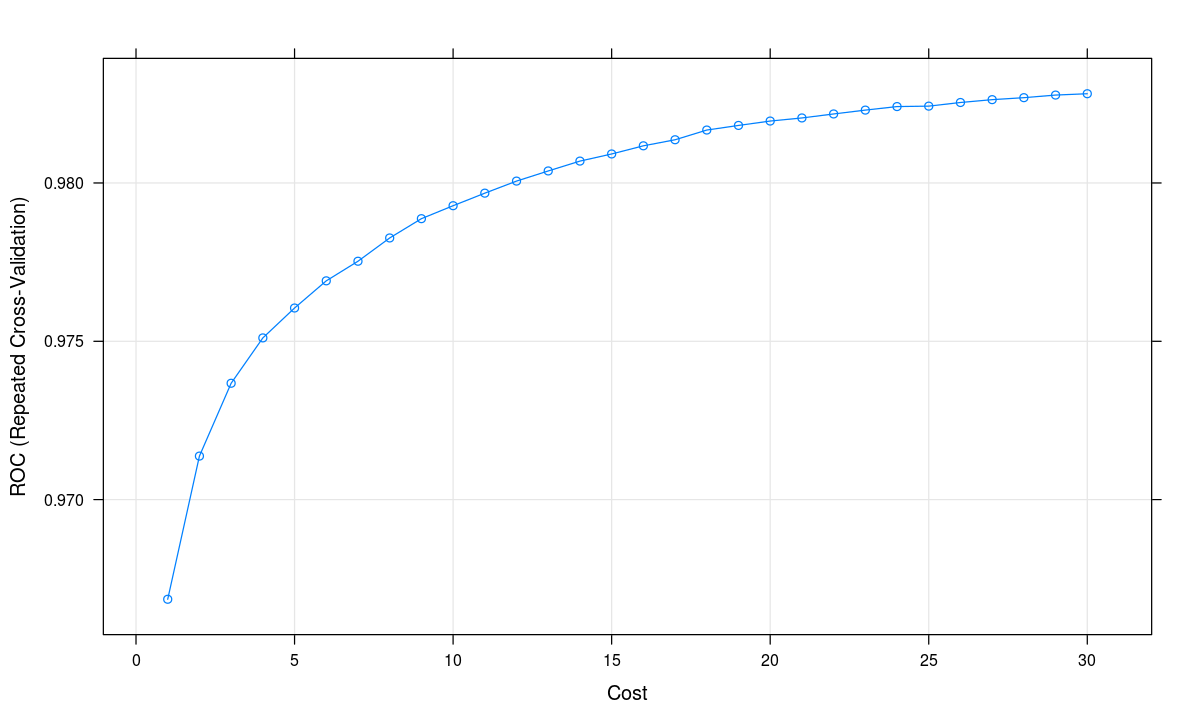

In [17]:
# plot ROC over all levels of C
plot(svm_fit)

In [18]:
# use model to predict training data
svm_train <- predict(svm_fit, imbal_train, type = "prob")
svm_train$pred <- factor(ifelse(svm_train$down >= .50, "down", "notDown"))
svm_train <- cbind(svm_train, actual = imbal_train$Class)
confusionMatrix(data = svm_train$pred, reference = svm_train$actual, positive = 'down')

Warning message in confusionMatrix.default(data = svm_train$pred, reference = svm_train$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown down
   notDown    5809    5
   down        123  232
                                          
               Accuracy : 0.9793          
                 95% CI : (0.9754, 0.9827)
    No Information Rate : 0.9616          
    P-Value [Acc > NIR] : 2.239e-15       
                                          
                  Kappa : 0.7733          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.97890         
            Specificity : 0.97927         
         Pos Pred Value : 0.65352         
         Neg Pred Value : 0.99914         
             Prevalence : 0.03842         
         Detection Rate : 0.03761         
   Detection Prevalence : 0.05755         
      Balanced Accuracy : 0.97908         
                                          
       'Positive' Class : down            
                                          

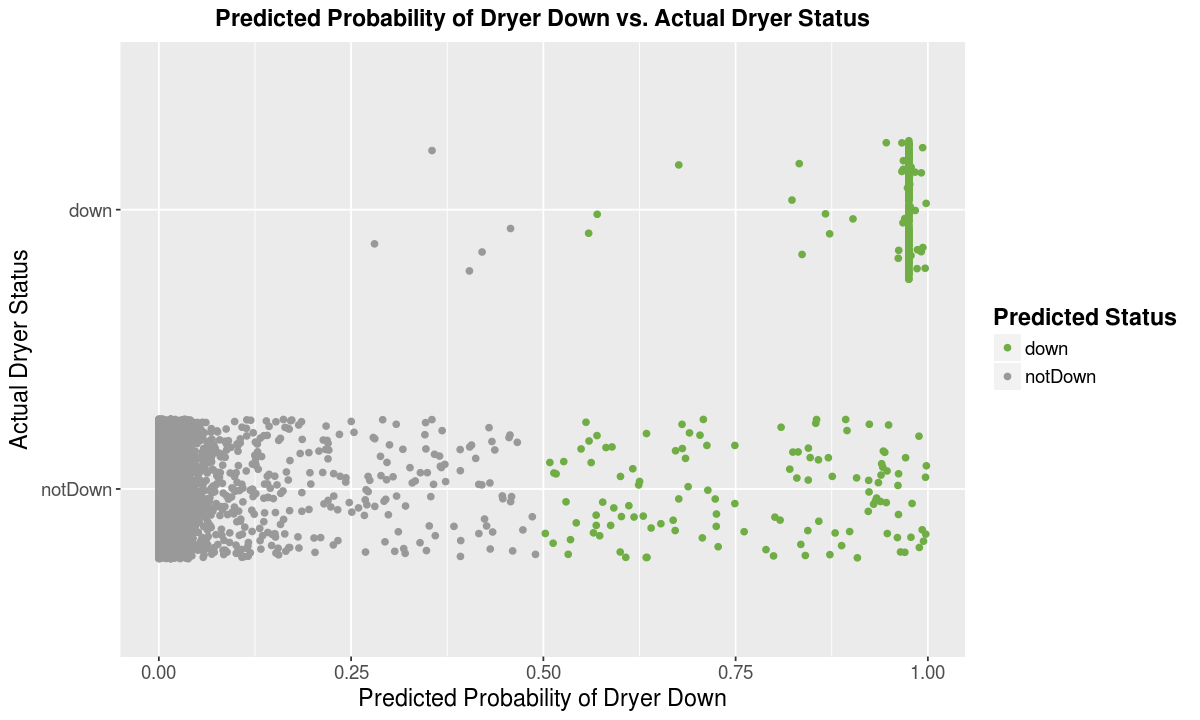

In [19]:
# plot the posterior probability vs actual
ggplot(data = svm_train) +
  geom_point(mapping = aes(x = down, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  theme(text = element_text(size = 14)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5, size = 14), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold", size=14), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#70AE45", "#999999"))

In [20]:
# use model to predict test data
svm_test <- predict(svm_fit, imbal_test, type = "prob")
svm_test$pred <- factor(ifelse(svm_test$down >= 0.50, "down", "notDown"))
svm_test <- cbind(svm_test, actual = imbal_test$Class)
confusionMatrix(data = svm_test$pred, reference = svm_test$actual, positive = 'down')

Warning message in confusionMatrix.default(data = svm_test$pred, reference = svm_test$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown down
   notDown    1891   71
   down         86    8
                                          
               Accuracy : 0.9236          
                 95% CI : (0.9113, 0.9348)
    No Information Rate : 0.9616          
    P-Value [Acc > NIR] : 1.0000          
                                          
                  Kappa : 0.0529          
 Mcnemar's Test P-Value : 0.2639          
                                          
            Sensitivity : 0.101266        
            Specificity : 0.956500        
         Pos Pred Value : 0.085106        
         Neg Pred Value : 0.963812        
             Prevalence : 0.038424        
         Detection Rate : 0.003891        
   Detection Prevalence : 0.045720        
      Balanced Accuracy : 0.528883        
                                          
       'Positive' Class : down            
                                          

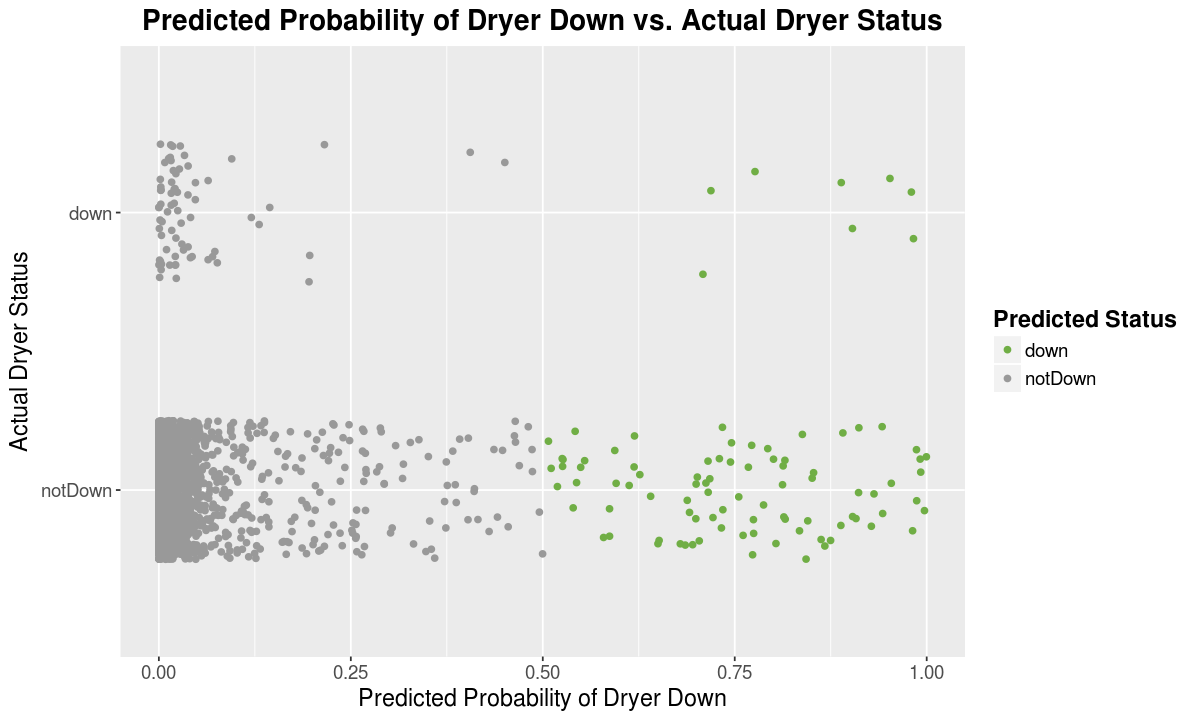

In [21]:
# plot the posterior probability vs actual
ggplot(data = svm_test) +
  geom_point(mapping = aes(x = down, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  theme(text = element_text(size = 14)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#70AE45", "#999999"))

In [22]:
# use model to predict validation data
svm_valid <- predict(svm_fit, imbal_valid, type = "prob")
svm_valid$pred <- factor(ifelse(svm_valid$down >= 0.50, "down", "notDown"))
svm_valid <- cbind(svm_valid, actual = imbal_valid$Class)
confusionMatrix(data = svm_valid$pred, reference = svm_valid$actual, positive = 'down')

Warning message in confusionMatrix.default(data = svm_valid$pred, reference = svm_valid$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown down
   notDown    1889   74
   down         88    5
                                          
               Accuracy : 0.9212          
                 95% CI : (0.9087, 0.9325)
    No Information Rate : 0.9616          
    P-Value [Acc > NIR] : 1.0000          
                                          
                  Kappa : 0.0173          
 Mcnemar's Test P-Value : 0.3071          
                                          
            Sensitivity : 0.063291        
            Specificity : 0.955488        
         Pos Pred Value : 0.053763        
         Neg Pred Value : 0.962303        
             Prevalence : 0.038424        
         Detection Rate : 0.002432        
   Detection Prevalence : 0.045233        
      Balanced Accuracy : 0.509390        
                                          
       'Positive' Class : down            
                                          

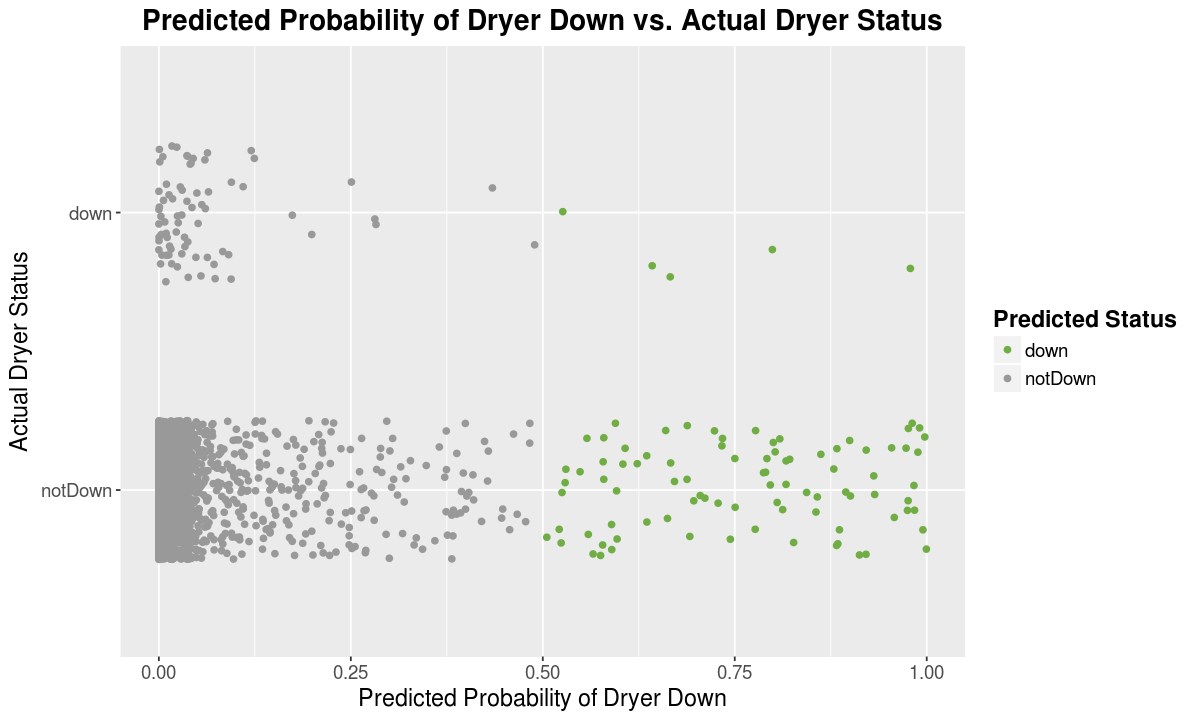

In [23]:
# plot the posterior probability vs actual
ggplot(data = svm_valid) +
  geom_point(mapping = aes(x = down, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  theme(text = element_text(size = 14)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#70AE45", "#999999"))

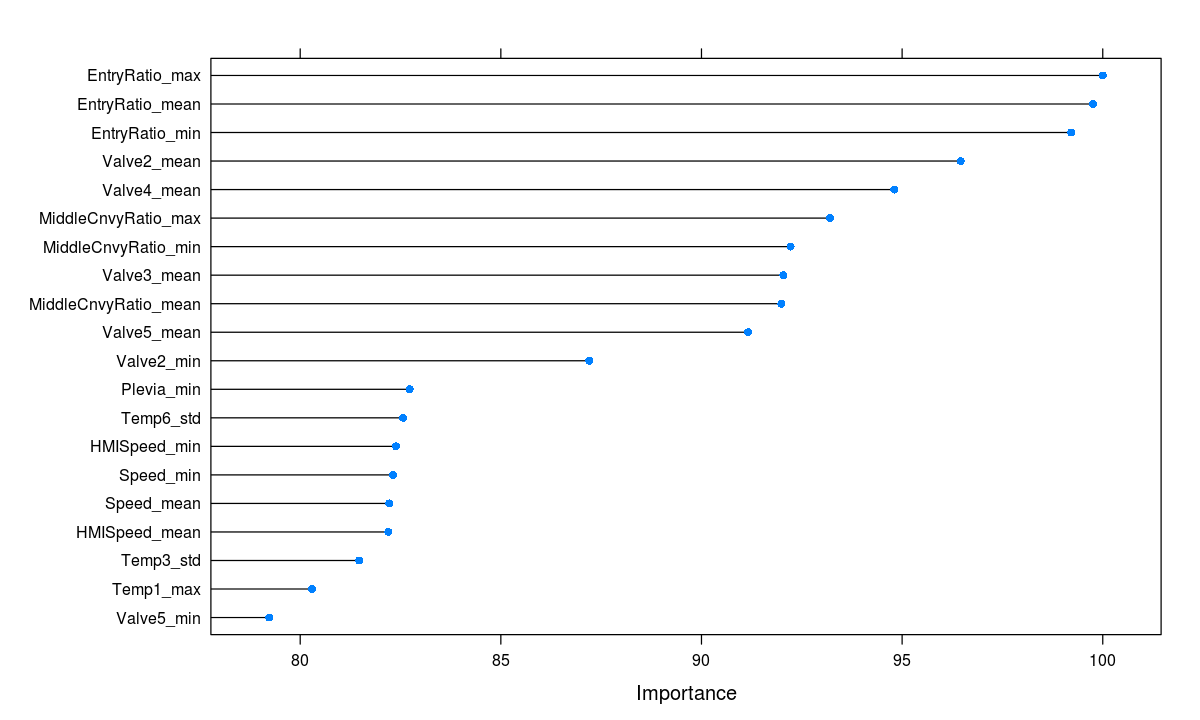

In [24]:
impVars <- varImp(svm_fit)
plot(impVars, top=20)

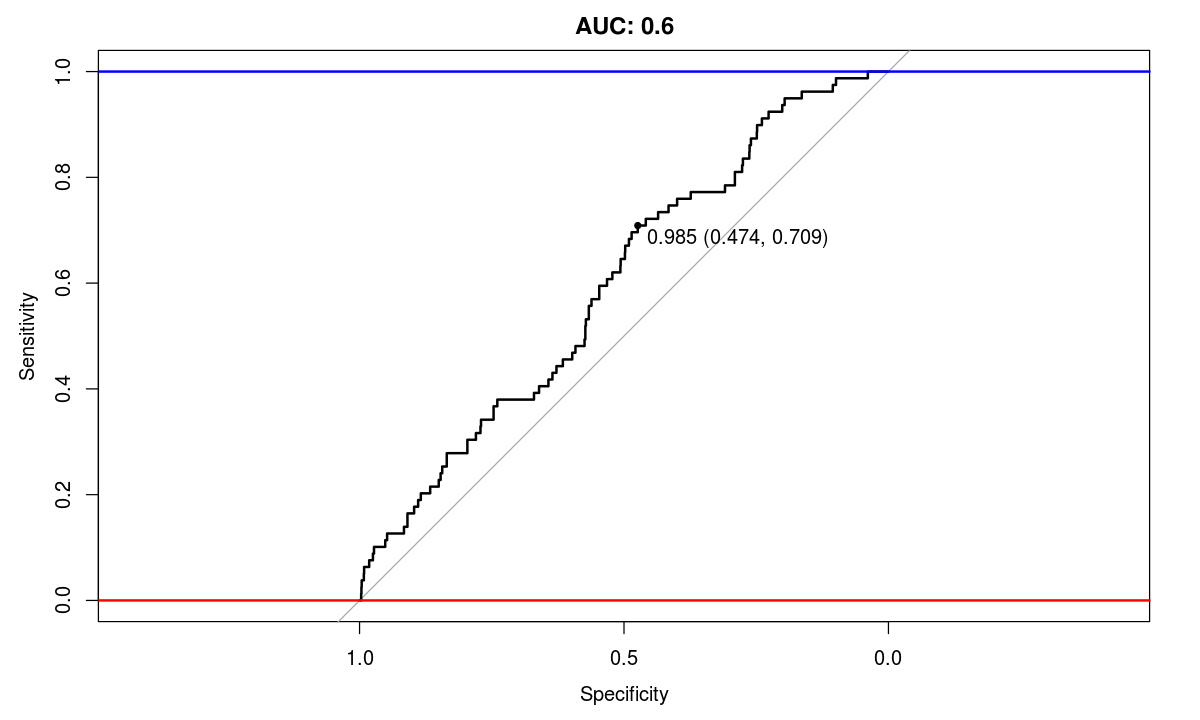

In [25]:
auc <- roc(imbal_test$Class, svm_test$notDown)
plot(auc, ylim=c(0,1), print.thres=TRUE, main=paste('AUC:',round(auc$auc[[1]],2)))
abline(h=1,col='blue',lwd=2)
abline(h=0,col='red',lwd=2)

In [26]:
# combine predicted probabiliteis from the test dataset with the datatimes for that dataset
test_results <- cbind(svm_test, datetime = test_dt, dataset = "test")
valid_results <- cbind(svm_valid, datetime = valid_dt, dataset = "valid")
results <- rbind(test_results, valid_results)

In [27]:
# look at the dates that were correctly predicted as down
results[(results$pred == "down" & results$actual == "down"), ]

,notDown,down,pred,actual,datetime,dataset
96,0.09670974,0.9032903,down,down,2015-01-21 05:00:00,test
231,0.29140018,0.7085998,down,down,2015-03-01 12:00:00,test
620,0.28099883,0.7190012,down,down,2015-05-24 04:00:00,test
676,0.11124874,0.8887513,down,down,2015-06-05 00:00:00,test
1187,0.01993608,0.9800639,down,down,2015-10-11 11:00:00,test
1331,0.22360248,0.7763975,down,down,2015-11-18 06:00:00,test
1388,0.01722478,0.9827752,down,down,2015-12-05 05:00:00,test
1675,0.04783508,0.9521649,down,down,2016-03-18 08:00:00,test
2482,0.20101929,0.7989807,down,down,2015-04-12 08:00:00,valid
3199,0.33400862,0.6659914,down,down,2015-09-23 13:00:00,valid


In [28]:
# write all results to CSV
write.csv(results, "SVM_predicted_probabilities.csv")

In [29]:
# write variable importance to CSV
write.csv(impVars[1], "SVM_variable_importance.csv")